## Requires numpy 1.9 and python 3.7

In [1]:
import csv
import os

path = "ePillID_data/all_labels.csv"

In [2]:
labels = []
dataset = []

i = 0
with open (path, "r") as file:
    csv_reader = csv.reader(file)
    
    for row in csv_reader:
        if i == 0:
            labels = row
            i+=1
            continue
        dataset.append(row)
        i+=1
print(f"Number data points: {i-1}")
print(labels)

Number data points: 13532
['images', 'pilltype_id', 'label_code_id', 'prod_code_id', 'is_ref', 'is_front', 'is_new', 'image_path', 'label']


In [3]:
count_backs = 0
count_fronts = 0
for data in dataset:
    if data[5] == "True":
        count_fronts+=1
    else:
        count_backs+=1
print(f"total front images: {count_fronts}")
print(f"total back images: {count_backs}")

total front images: 6937
total back images: 6595


In [4]:
num_cust_images = 0
for data in dataset:
    if data[4] == "False":
        num_cust_images+=1
    
print(num_cust_images)

3728


In [5]:
by_pill_id = {}

for idx, data in enumerate(dataset):
    if data[1] not in by_pill_id:
        tmp = []
        tmp.append(data)
        by_pill_id[data[1]] = tmp
    else:
        by_pill_id[data[1]].append(data) # pilltype id

In [6]:
for data in dataset:
    if data[4] == "True":
        print(data)

['00002-3228-30_PART_1_OF_1_CHAL10_SB_391E1C80.jpg', '00002-3228-30_391E1C80', '2', '3228', 'True', 'False', 'False', 'fcn_mix_weight/dr_224/00002-3228-30_PART_1_OF_1_CHAL10_SB_391E1C80.jpg', '00002-3228-30_391E1C80']
['00002-3228-30_PART_1_OF_1_CHAL10_SF_391E1C80.jpg', '00002-3228-30_391E1C80', '2', '3228', 'True', 'True', 'False', 'fcn_mix_weight/dr_224/00002-3228-30_PART_1_OF_1_CHAL10_SF_391E1C80.jpg', '00002-3228-30_391E1C80']
['00002-3229-30_PART_1_OF_1_CHAL10_SB_3E1E1F50.jpg', '00002-3229-30_3E1E1F50', '2', '3229', 'True', 'False', 'False', 'fcn_mix_weight/dr_224/00002-3229-30_PART_1_OF_1_CHAL10_SB_3E1E1F50.jpg', '00002-3229-30_3E1E1F50']
['00002-3229-30_PART_1_OF_1_CHAL10_SF_3E1E1F50.jpg', '00002-3229-30_3E1E1F50', '2', '3229', 'True', 'True', 'False', 'fcn_mix_weight/dr_224/00002-3229-30_PART_1_OF_1_CHAL10_SF_3E1E1F50.jpg', '00002-3229-30_3E1E1F50']
['00002-3238-30_PART_1_OF_1_CHAL10_SB_361E1B30.jpg', '00002-3238-30_361E1B30', '2', '3238', 'True', 'False', 'False', 'fcn_mix_wei

In [7]:
info = {}
for idx, data_list in enumerate(by_pill_id.values()):
        print(data_list)

[['0.jpg', '51285-0092-87_BE305F72', '51285', '92', 'False', 'False', 'False', 'fcn_mix_weight/dc_224/0.jpg', '51285-0092-87_BE305F72'], ['1740.jpg', '51285-0092-87_BE305F72', '51285', '92', 'False', 'False', 'False', 'fcn_mix_weight/dc_224/1740.jpg', '51285-0092-87_BE305F72'], ['1924.jpg', '51285-0092-87_BE305F72', '51285', '92', 'False', 'True', 'False', 'fcn_mix_weight/dc_224/1924.jpg', '51285-0092-87_BE305F72'], ['3560.jpg', '51285-0092-87_BE305F72', '51285', '92', 'False', 'True', 'False', 'fcn_mix_weight/dc_224/3560.jpg', '51285-0092-87_BE305F72'], ['7.jpg', '51285-0092-87_BE305F72', '51285', '92', 'False', 'False', 'False', 'fcn_mix_weight/dc_224/7.jpg', '51285-0092-87_BE305F72'], ['51285-0092-87_PART_1_OF_2_CHAL10_SB_BE305F72.jpg', '51285-0092-87_BE305F72', '51285', '92', 'True', 'False', 'False', 'fcn_mix_weight/dr_224/51285-0092-87_PART_1_OF_2_CHAL10_SB_BE305F72.jpg', '51285-0092-87_BE305F72'], ['51285-0092-87_PART_1_OF_2_CHAL10_SF_BE305F72.jpg', '51285-0092-87_BE305F72', '51

In [8]:
tmp = by_pill_id.values()

## Using the image augmentation function from the paper seen here: https://github.com/usuyama/ePillID-benchmark/blob/master/src/image_augmentators.py

In [39]:
from imgaug import augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)


def get_imgaug_sequences(low_gblur = 1.0, 
high_gblur = 3.0, addgn_base_ref = 0.01, 
addgn_base_cons = 0.001, rot_angle = 180, 
max_scale = 1.0, add_perspective = False
):
    affine_seq = iaa.Sequential([
            iaa.Affine(
                rotate=(-rot_angle, rot_angle),
                scale=(0.8, max_scale),
                translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            ),
            sometimes(iaa.Affine(
                shear=(-4, 4),
            ))
        ])
    
    affine_list = [affine_seq]

    contrast_list = [
            iaa.Sequential([
                iaa.LinearContrast((0.7, 1.0), per_channel=False), # change contrast
                iaa.Add((-30, 30), per_channel=False), # change brightness
            ]),
            iaa.Sequential([
                iaa.LinearContrast((0.4, 1.0), per_channel=False), # change contrast
                iaa.Add((-80, 80), per_channel=False), # change brightness
            ])            
        ]

    if add_perspective:
        print("Adding perspective transform to augmentation")
        affine_list =  affine_list + [
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                    ]
                          
            

        contrast_list = contrast_list + [ 
            iaa.GammaContrast((0.5, 1.7), per_channel=True),
            iaa.SigmoidContrast(gain=(8, 12), cutoff=(0.2,0.8), per_channel=False)
             ]

    

    ref_seq = iaa.Sequential(affine_list + [
        iaa.OneOf(contrast_list),
        iaa.OneOf([
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3*addgn_base_ref*255), per_channel=0.5),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, addgn_base_ref*255), per_channel=0.5),
        ]),
        iaa.OneOf([
            iaa.GaussianBlur(sigma=(0, high_gblur)),
            iaa.GaussianBlur(sigma=(0, low_gblur)),
        ])
    ])

    cons_seq = iaa.Sequential(affine_list + [
        iaa.LinearContrast((0.9, 1.1), per_channel=False),
        iaa.Add((-10, 10), per_channel=False),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 5*addgn_base_cons*255), per_channel=0.5),
        iaa.GaussianBlur(sigma=(0, low_gblur)),
    ])
    
    return affine_seq, ref_seq, cons_seq

In [40]:
affine_seq, ref_seq, cons_seq = get_imgaug_sequences()

In [41]:
affine_seq

Sequential(name=UnnamedSequential, random_order=False, children=[Affine(name=UnnamedAffine, parameters=[Uniform(Deterministic(float 0.80000000), Deterministic(float 1.00000000)), (Uniform(Deterministic(float -0.05000000), Deterministic(float 0.05000000)), Uniform(Deterministic(float -0.05000000), Deterministic(float 0.05000000)), 'percent'), Uniform(Deterministic(int -180), Deterministic(int 180)), Deterministic(float 0.00000000), Deterministic(int 1), Deterministic(int 0), Deterministic(constant), auto, False], deterministic=False), Sometimes(p=Binomial(Deterministic(float 0.50000000)), name=UnnamedSometimes, then_list=Sequential(name=UnnamedSometimes-then, random_order=False, children=[Affine(name=UnnamedAffine, parameters=[Deterministic(float 1.00000000), (Deterministic(int 0), None, 'px'), Deterministic(float 0.00000000), Uniform(Deterministic(int -4), Deterministic(int 4)), Deterministic(int 1), Deterministic(int 0), Deterministic(constant), auto, False], deterministic=False)], de

## Lets see if these image augmentations work

In [42]:
from PIL import Image
import numpy as np

img_path = "ePillID_data/classification_data/segmented_nih_pills_224/54868-6176_0_0.jpg"

image = Image.open(img_path)
image.show()

image_np = np.array(image)

In [48]:
aug_image = affine_seq.augment_images([image_np])
aug_image = ref_seq.augment_images(aug_image)
aug_image = cons_seq.augment_images(aug_image)

/home/tyler/anaconda3/envs/epill/lib/python3.8/site-packages/imgaug/augmenters/meta.py:3368: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  augmenter_active = np.zeros((nb_rows, len(self)), dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [44]:
aug_image[0].shape

(224, 224, 3)

In [45]:
image = aug_image[0]
image = Image.fromarray(image)

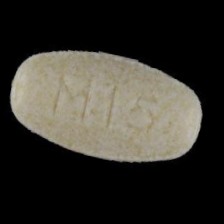

In [46]:
image